# Diffmah
Run Andrew's diffmah model on halos from LJ to explore the smooth mass accretion history of different types of halos (fossils, non-fossils, rugs, etc.)

There's lots of background code here: scroll to **"The Main Event"** or, if you don't want to rerun the calculation, scroll to **"(Start here): Reload findings"**

In [7]:
import io
import copy
import h5py
import pickle
import numba
import numpy as np
import pandas as pd
import seaborn as sns
import haccytrees.mergertrees
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from itertools import groupby
from matplotlib.ticker import ScalarFormatter
from matplotlib.patches import Circle, Wedge, Ellipse
from matplotlib.collections import PatchCollection

from diffmah.diffmah.load_mah_data import load_tng_data, TASSO
from diffmah.diffmah.fit_mah_helpers import get_loss_data
from diffmah.diffmah.fit_mah_helpers import log_mah_mse_loss_and_grads
from diffmah.diffmah.utils import jax_adam_wrapper
from diffmah.diffmah.individual_halo_assembly import _calc_halo_history
from diffmah.diffmah.individual_halo_assembly import _get_early_late

# chronological order (changed on 7/6)
redshifts = np.array([10.044, 9.8065, 9.5789, 9.3608, 9.1515, 8.7573, 8.5714, 8.3925, 8.0541, 7.8938, 7.7391, 7.4454, 7.3058, 7.04, 6.9134, 6.6718, 6.5564, 6.3358, 6.1277, 6.028, 5.8367, 5.6556, 5.4839, 5.3208, 5.2422, 5.0909, 4.9467, 4.7429, 4.6145, 4.4918, 4.3743, 4.2618, 4.1015, 4.00, 3.8551, 3.763, 3.6313, 3.5475, 3.4273, 3.3133, 3.205, 3.102, 3.0361, 2.9412, 2.8506, 2.7361, 2.6545, 2.5765, 2.4775, 2.4068, 2.3168, 2.2524, 2.1703, 2.0923, 2.018, 1.9472, 1.8797, 1.7994, 1.7384, 1.68, 1.6104, 1.5443, 1.4938, 1.4334, 1.3759, 1.321, 1.2584, 1.2088, 1.152, 1.1069, 1.0552, 1.006, 0.9591, 0.9143, 0.8646, 0.824, 0.7788, 0.7358, 0.6948, 0.6557, 0.6184, 0.5777, 0.5391, 0.5022, 0.4714, 0.4337, 0.4017, 0.3636, 0.3347, 0.3035, 0.2705, 0.2423, 0.2123, 0.1837, 0.1538, 0.1279, 0.1008, 0.0749, 0.0502, 0.0245, 0.00])

%load_ext line_profiler
%reload_ext autoreload
%autoreload 1
%aimport help_func_haccytrees
plt.rc('figure', facecolor='w')

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [8]:
sim = haccytrees.Simulation.simulations["LastJourney"]
z = sim.step2z(np.array(sim.cosmotools_steps)) # same as redshifts, chronological

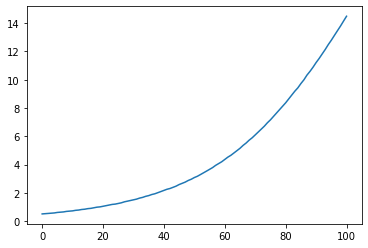

In [9]:
import diffmah
simulation = haccytrees.Simulation.simulations['LastJourney'] # read in a chunk of simulation
cosmic_time = simulation.cosmo.lookback_time(1e-10) - simulation.step2lookback(np.array(simulation.cosmotools_steps))
fig, ax = plt.subplots()
ax.plot(cosmic_time) # cosmic time vs timesteps

In [10]:
%%time
# No mass threshold! We want as much info as possible
forest, progenitor_array = haccytrees.mergertrees.read_forest(
    '/data/a/cpac/mbuehlmann/LastJourney/forest/target_forest_aurora.hdf5',
    'LastJourney', nchunks=1, chunknum=0, #mass_threshold = 2.7*10**11,
    include_fields = ["tree_node_mass", "snapnum", "fof_halo_tag", "sod_halo_cdelta", "fof_halo_center_x", "fof_halo_center_y", "fof_halo_center_z", "xoff_fof"]
)

CPU times: user 6.12 s, sys: 9.33 s, total: 15.5 s
Wall time: 15.4 s


In [5]:
%%time
fg_forest, fg_progenitor_array = haccytrees.mergertrees.read_forest(
    "/data/a/cpac/mbuehlmann/LastJourney/forest/fg_forest.hdf5",
    'LastJourney'
)

CPU times: user 23.1 s, sys: 41.8 s, total: 1min 4s
Wall time: 1min 4s


## Get halo samples (via masking)

In [6]:
fg_masks = help_func_haccytrees.make_masks(fg_forest)
halo_masks = help_func_haccytrees.make_masks(forest) # All z=0 halos # Same as `halo_masks2 = make_masks(forest, target_idx = target_idx)` because of mass bins

## Helper Functions

#### Calculating diffmah best-fit params

In [7]:
# Calculate their parameters
def calc_subset_params(subset, forest, lgm_min = np.log10(100*simulation.particle_mass)):
    """
    Parameters
    ----------
    subset: ndarray of shape (nhalos,)
        Halo ids of halos whose MAH you would like to fit with diffmah. If fitting multiple classes
        (i.e. fossils, non-fossils), store those halo ids in order so it is easy to identify class 
        later
    forest: 
        merger tree forest associated with the subset of halos you are fitting with diffmah
        (if you are fitting multiple classes and they use different forests, you will need to run
        calc_subset_params once for each class)
    lgm_min: float, optional
        Base-10 log of the minimum halo mass you would like the diffmah fitter to consider. Default is
        100 times the simulation mass resolution.
    """
    mainbranch_index, mainbranch_masses = help_func_haccytrees.get_branches(subset, forest)
    mainbranch_peakmass = np.maximum.accumulate(mainbranch_masses, axis=1)
    mainbranch_peakmass[~np.isfinite(mainbranch_peakmass)] = 0
    mainbranch_peakmass = np.log10(mainbranch_peakmass)
    
    cosmo = FlatLambdaCDM(H0=67.77, Om0=0.31)
    cosmic_times = cosmo.age(redshifts).value
    lgtarr = np.log10(cosmic_times)
    size = len(subset)
    subset_params = np.zeros((size, 4))
    log_mah_fit_lst = []
    dmhdt_fit_lst = []
    
    for ihalo in range(size):
        p_init, loss_data = get_loss_data(cosmic_times, mainbranch_peakmass[ihalo], lgm_min) # used to use t_tng in place of cosmic_times
        n_step = 150
        _res = jax_adam_wrapper(log_mah_mse_loss_and_grads, p_init, loss_data, n_step, n_warmup=1)
        p_best, loss, loss_arr, params_arr, fit_terminates = _res
        logtc, ue, ul = p_best
        logt_target, log_mah_target, logtmp, k, logmp_fit = loss_data # logmpfit is just one number... that's cause it's the present day peak mass
        early, late = _get_early_late(ue, ul)
        
        # Save the best fit parameters (plus peak mass)
        subset_params[ihalo,:] = [logmp_fit, early, late, logtc] # x0 is now logtc
        
        # Save the diffmah fits and slopes
        dmhdt_fit, log_mah_fit = _calc_halo_history(lgtarr, lgtarr[-1], logmp_fit, logtc, k, early, late)
        log_mah_fit_lst.append(log_mah_fit)
        dmhdt_fit_lst.append(dmhdt_fit)
        
    # Add on z50s, z80s, concentrations, and relaxations
    z10s = help_func_haccytrees.get_zfracs(forest, redshifts, subset, mainbranch_masses, frac = 0.1)
    z25s = help_func_haccytrees.get_zfracs(forest, redshifts, subset, mainbranch_masses, frac = 0.25)
    z50s = help_func_haccytrees.get_zfracs(forest, redshifts, subset, mainbranch_masses, frac = 0.5)
    z80s = help_func_haccytrees.get_zfracs(forest, redshifts, subset, mainbranch_masses, frac = 0.8)
    cdeltas = forest['sod_halo_cdelta'][subset] # Hopefully this is right?
    relaxations = forest['xoff_fof'][subset]
    subset_params = np.concatenate((subset_params, np.array([z10s]).T, np.array([z25s]).T, np.array([z50s]).T, np.array([z80s]).T, np.array([cdeltas]).T, np.array([relaxations]).T), axis = 1)

    return subset_params, log_mah_fit_lst, dmhdt_fit_lst

### Plotting helper functions

In [11]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
def _contour_level(data, levels):
    data_flat = np.sort(data.flatten())[::-1]
    data_cm = np.cumsum(data_flat)
    assert data_cm[-1] <= 1.00001
    contour_level = np.empty(len(levels))
    for i, l in enumerate(levels):
        try:
            contour_level[i] = data_flat[data_cm <= l][-1]
        except:
            contour_level[i] = data_flat[0]  # If there is no element with data_cm <= l
    return np.sort(contour_level)  # sort, because contour plot requires levels in ascending order
def _plot_1d_hist(data, bins, ax, kde=True, **kwargs):
    if kde:
        kernel = scipy.stats.gaussian_kde(data)
        hist = kernel(bins)
        ax.plot(bins, hist, **kwargs)
    else:
        ax.hist(data, bins=bins, histtype='step', **kwargs)
def _plot_2d_hist(data_x, data_y, bins_x, bins_y, ax, levels, kde=True, **kwargs):
    if kde:
        kernel = scipy.stats.gaussian_kde(np.vstack((data_x, data_y)))
        xx, yy = np.meshgrid(bins_x, bins_y, indexing='ij')
        hist2d = kernel(np.vstack((xx.ravel(), yy.ravel()))).reshape(xx.shape) # problem here, or above
    else:
        hist2d, _, _, = np.histogram2d(data_x, data_y, [bins_x, bins_y])
        bins_x = 0.5*(bins_x[1:] + bins_x[:-1])
        bins_y = 0.5*(bins_y[1:] + bins_y[:-1])
    # find contour levels
    hist2d /= np.sum(hist2d)
    clevs = _contour_level(hist2d, levels)
    if 'linewidth' in kwargs:
        kwargs['linewidths'] = kwargs['linewidth'] #- 0.5
    if 'linestyle' in kwargs:
        kwargs['linestyles'] = [kwargs['linestyle']]
    ax.contour(bins_x, bins_y, hist2d.T, levels=clevs, **kwargs)
    return fig, ax

In [12]:
def jointplot(
        *data, # Unpackable? Aha, because you can have multiple sets
        levels=[0.1, 0.5, 0.9], 
        colors=None,
        linestyles=None,
        bin_edges=None, 
        prop_labels=None,
        data_labels=None,
        fig=None,
        **kwargs):
    ndata = len(data) # Number of data sets (for us, this is 3)
    nprops = data[0].shape[1] # Number of properties
    # consistency checks
    assert np.all([data[i].shape[1] == nprops for i in range(ndata)])
    if bin_edges is not None:
        assert len(bin_edges) == nprops
    if prop_labels is not None:
        assert len(prop_labels) == nprops
    else:
        prop_labels = [f'prop {p}' for p in range(nprops)] # Why is this sometimes f and sometimes r?
    if data_labels is not None:
        assert len(data_labels) == ndata
    else:
        data_labels = [f'data {i}' for i in range(ndata)]
    # colors
    if colors is None:
        if ndata <= 10:
            colors = [plt.cm.tab10(i) for i in range(ndata)]
        else:
            raise NotImplementedError("please specify colors")
    # linestyles      
    if linestyles is None:
        linestyles = np.resize('-', ndata)
    # Creating figure and axes
    if fig is None:
        fig = plt.figure(figsize=(10, 10))
    gs = plt.matplotlib.gridspec.GridSpec(nprops, nprops, figure=fig, hspace=0, wspace=0)
    axes = np.array([[
            fig.add_subplot(gs[i, j]) if j <= i else None
            for j in range(nprops)]
        for i in range(nprops)])
    # Finding bin edges
    if bin_edges is None:
        bin_edges = [(
            min(np.min(data[i][:, p]) for i in range(ndata)),
            max(np.max(data[i][:, p]) for i in range(ndata))
            ) for p in range(nprops)]
        #print(bin_edges)
        # default nbins=50
        bin_edges = [
            np.linspace(*be, 51, endpoint=True) for be in bin_edges
        ]
        #print(bin_edges)
    # Doing 1D histograms
    for p in range(nprops):
        for i in range(ndata):
            _plot_1d_hist(
                data[i][:, p], 
                bin_edges[p], 
                axes[p, p],
                color=colors[i],
                label=data_labels[i],
                linestyle = linestyles[i],
                **kwargs
            )
    # Doing 2D histograms
    for py in range(nprops):
        for px in range(py):
            for i in range(ndata):
                _plot_2d_hist(
                    data[i][:, px], 
                    data[i][:, py], 
                    bin_edges[px], 
                    bin_edges[py], 
                    axes[py, px], 
                    levels=levels, 
                    colors=colors[i], 
                    linestyle = linestyles[i], 
                    **kwargs 
                )
    # Setting limits
    for py in range(nprops): # 0 to 7
        for px in range(py+1): # 0 to 1, 0 to 2, 0 to 3,... 0 to 8
            axes[py, px].set_xlim(bin_edges[px][[0,-1]]) # always set these limits
            if px < py:
                axes[py, px].set_ylim(bin_edges[py][[0,-1]]) # only set the limits below the diagonal
            if py == nprops-1:
                axes[py, px].set_xlabel(prop_labels[px]) # only set the x labels when you're on the last y (highest?) I guess that's when you look at the whole x-axis. All labels at once, I guess?
            else:
                axes[py, px].set_xticklabels([]) # if not on the last y (highest), set the x ticks
            if px == 0 and py > 0:
                axes[py, px].set_ylabel(prop_labels[py]) # only set the y labels when climbing up the y side (but do it all at once)
            else:
                axes[py, px].set_yticklabels([]) # set y-ticks everywhere else (not just when climbing up the y side)
    # Removing boundaries from diagonal plots
    for p in range(nprops):
        axes[p, p].set_ylim(bottom=0)
        axes[p, p].spines['top'].set_visible(False)
        axes[p, p].spines['right'].set_visible(False)
        axes[p, p].spines['left'].set_visible(False)
        axes[p, p].xaxis.set_ticks_position('bottom')
        axes[p, p].set_yticks([])
        # make background transparent
        axes[p, p].set_facecolor("none")
    # Setting labels
    return fig, axes


In [13]:
def create_zoom(fig, ax, zoom_relsize=1.5, zoom_padding=0., highlight_color='#cc0000'):
    figbox_00 = axes[0, 0].get_subplotspec().get_position(fig)
    figbox_11 = axes[-1, -1].get_subplotspec().get_position(fig)
    zoom_size = np.array([figbox_00.width, figbox_00.height])
    zoom_right = np.array([
        figbox_11.x1-zoom_size[0]*zoom_padding, 
        figbox_00.y1-zoom_size[1]*zoom_padding])
    zoom_size *= zoom_relsize
    zoom_left = zoom_right - zoom_size
    zoom_ax_dummy = fig.add_axes([zoom_left[0], zoom_left[1], zoom_size[0], zoom_size[1]])
    # duplicate figure, extract axes
    inx = list(fig.axes).index(ax)
    print(inx)
    buf = io.BytesIO()
    pickle.dump(fig, buf)
    buf.seek(0)
    fig2 = pickle.load(buf) 
    for i, _ax in enumerate(fig2.axes):
        if i != inx:
            fig2.delaxes(_ax)
        else:
            zoom_ax=_ax
    # move copied axes to original figure
    zoom_ax.remove()
    zoom_ax.figure = fig
    fig.axes.append(zoom_ax)
    fig.add_axes(zoom_ax)
    zoom_ax.set_position(zoom_ax_dummy.get_position())
    zoom_ax_dummy.remove()
    # highlight zoom region
    for spine in ['bottom', 'top', 'right', 'left']:
        ax.spines[spine].set_color(highlight_color)
        ax.spines[spine].set_linewidth(3)
        zoom_ax.spines[spine].set_color(highlight_color)
        zoom_ax.spines[spine].set_linewidth(3)
    # move to front
    ax.set_zorder(100)
    zoom_ax.set_zorder(101)
    # restore ticks
    zoom_ax.yaxis.set_major_locator(plt.matplotlib.ticker.AutoLocator())
    zoom_ax.xaxis.set_major_locator(plt.matplotlib.ticker.AutoLocator())
    zoom_ax.set_xticklabels(zoom_ax.get_xticks())
    zoom_ax.set_yticklabels(zoom_ax.get_yticks())
    zoom_ax.xaxis.set_tick_params(which='both', labelbottom=True, width=2)
    zoom_ax.yaxis.set_tick_params(which='both', labelleft=True, width=2)
    return zoom_ax, fig

## The Main Event (with non-overlapping samples)

In [ ]:
%%time
# Pick a mass bin
mass_bin = 0
my_fg_mask = fg_masks[mass_bin]
my_halo_mask = halo_masks[mass_bin]

# Find fgs within forest
rs_fg_qh_idx = np.nonzero(my_halo_mask)[0]
rs_fg_qh_mainbranch_index, rs_fg_qh_mainbranch_masses = help_func_haccytrees.get_branches(rs_fg_qh_idx, forest)
rs_fg_qh_mainbranch_mergers = help_func_haccytrees.get_mainbranch_mergers(forest, progenitor_array, rs_fg_qh_mainbranch_index)
rs_fg_qh_major_mergers = help_func_haccytrees.get_major_mergers(rs_fg_qh_mainbranch_mergers)
rs_fg_qh_lmm_redshift = help_func_haccytrees.get_lmms(rs_fg_qh_major_mergers)
rs_fgs, rs_qhs, mrich = help_func_haccytrees.find_specials(forest, rs_fg_qh_mainbranch_index, rs_fg_qh_major_mergers, rs_fg_qh_lmm_redshift, rs_fg_qh_idx)
non_idx = np.delete(rs_fg_qh_idx, np.concatenate((np.argwhere(np.isin(rs_fg_qh_idx, rs_qhs)), np.argwhere(np.isin(rs_fg_qh_idx, rs_fgs)))))

# Find qhs within fg_forest
fg_qh_idx = np.nonzero(my_fg_mask)[0]
fg_qh_mainbranch_index, fg_qh_mainbranch_masses = help_func_haccytrees.get_branches(fg_qh_idx, fg_forest)
fg_qh_mainbranch_mergers = help_func_haccytrees.get_mainbranch_mergers(fg_forest, fg_progenitor_array, fg_qh_mainbranch_index)
fg_qh_major_mergers = help_func_haccytrees.get_major_mergers(fg_qh_mainbranch_mergers)
fg_qh_lmm_redshift = help_func_haccytrees.get_lmms(fg_qh_major_mergers)
fgs, qhs, mrich = help_func_haccytrees.find_specials(fg_forest, fg_qh_mainbranch_index, fg_qh_major_mergers, fg_qh_lmm_redshift, fg_qh_idx)
fg_idx = np.delete(fg_rugs_idx, np.argwhere(np.isin(fg_qh_idx, qhs)))

# Define sample sizes
non_sample_size = 1000
fg_sample_size = 1000
if qhs != []:
    qh_sample_size = 1000 #len(rugs)
    size = fg_sample_size + qh_sample_size + non_sample_size
else:
    qh_sample_size = 0 #len(rugs)
    size = fg_sample_size + non_sample_size
    
# Create subsets
np.random.seed(0)
rs_subset = np.random.choice(non_idx, non_sample_size)
fg_subset = np.random.choice(fg_idx, fg_sample_size)
if qhs != []:
    qh_subset = np.random.choice(qhs, qh_sample_size)

In [ ]:
%%time
#rs_tpeak = cosmic_time[np.argmax(rs_subset, axis=1)] # Do we still need this part?
non_best_fit_params, non_log_mah_fits, non_dmdts = calc_subset_params(rs_subset, forest) # p_init is shape of number of params. How many params do I have? 3 fg, rugs, rs, but are those really parameters?
fg_only_best_fit_params, fg_only_log_mah_fits, fg_only_dmdts = calc_subset_params(fg_subset, fg_forest) 
qh_only_best_fit_params, qh_only_log_mah_fits, qh_only_dmdts = calc_subset_params(qh_subset, fg_forest)

In [ ]:
pickle.dump(non_best_fit_params, open( "save_new_non_list.p", "wb" ))
pickle.dump(fg_only_best_fit_params, open( "save_new_fg_only_list.p", "wb" ))
pickle.dump(qh_only_best_fit_params, open( "save_new_qh_only_list.p", "wb" ))

pickle.dump(non_log_mah_fits, open( "save_new_rs_log_mah_fits.p", "wb" ))
pickle.dump(fg_only_log_mah_fits, open( "save_new_fg_only_log_mah_fits.p", "wb" ))
pickle.dump(qh_only_log_mah_fits, open( "save_new_qh_only_log_mah_fits.p", "wb" ))

pickle.dump(non_dmdts, open( "save_new_non_dmdts.p", "wb" ))
pickle.dump(fg_only_dmdts, open( "save_new_fg_only_dmdts.p", "wb" ))
pickle.dump(qh_only_dmdts, open( "save_new_qh_only_dmdts.p", "wb" ))

## (Start here): Reload findings

In [14]:
pickled_non_params = pickle.load( open( "save_new_non_list.p", "rb" ))
pickled_fg_only_params = pickle.load( open( "save_new_fg_only_list.p", "rb" ))
pickled_qh_only_params = pickle.load( open( "save_new_qh_only_list.p", "rb" ))

pickled_non_log_mah_fits = pickle.load( open("save_new_rs_log_mah_fits.p", "rb" ))
pickled_fg_only_log_mah_fits = pickle.load( open("save_new_fg_log_mah_fits.p", "rb" ))
pickled_qh_only_log_mah_fits = pickle.load( open("save_new_qh_log_mah_fits.p", "rb" ))

pickled_non_dmdts = pickle.load( open("save_new_non_dmdts.p", "rb" ))
pickled_fg_only_dmdts = pickle.load( open("save_new_fg_only_dmdts.p", "rb" ))
pickled_qh_only_dmdts = pickle.load( open("save_new_qh_only_dmdts.p", "rb" ))

### Plot results

(9, 51)
(10000, 9)
(9,)


/home/acossairt/miniconda3/envs/fossil_groups_env/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: The following kwargs were not used by contour: 'linestyle', 'linewidth'
/home/acossairt/miniconda3/envs/fossil_groups_env/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


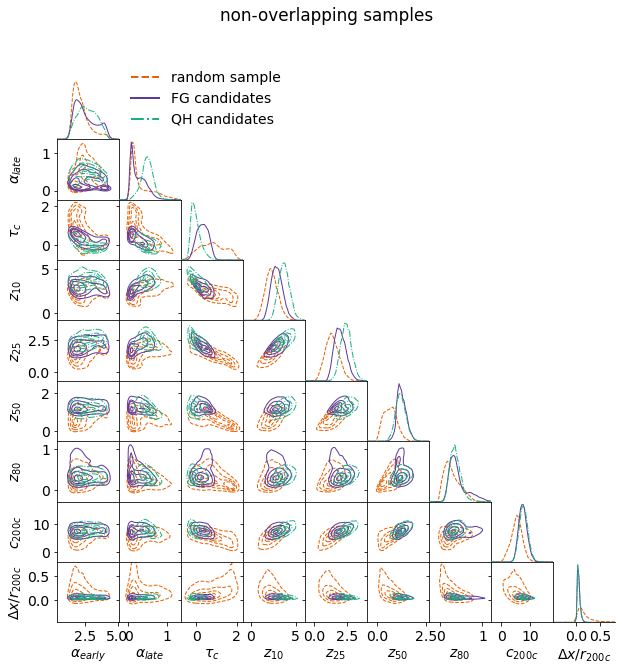

In [15]:
# Possible final version?

plt.rcParams.update({
    'font.size': 14,
    "figure.figsize": (10, 10), #(5.2, 3.13), #(5.4, 3.25), #(5.83, 3.5),#(6.25, 4.25), #(6.25, 3.75)
})

prop_labels = np.array([r"$M_{z=0}$", r"$\alpha_{early}$", r"$\alpha_{late}$", r"$\tau_c$", r"$z_{04}$", r"$z_{50}$", r"$z_{80}$", r"$c_{200c}$", r"$\Delta x/r_{200c}$"])

# Okay fine...
global_mins = [np.Inf for p in range(pickled_non_params.shape[1])] # HARD CODE (but should all be the same?)
global_maxs = [-np.Inf for p in range(pickled_non_params.shape[1])]
for data in [pickled_non_params, pickled_fg_only_params, pickled_qh_only_params]:
    mins = [np.min(data[:, p]) for p in range(data.shape[1])] # list containing min value of each property
    maxs = [np.max(data[:, p]) for p in range(data.shape[1])] # data.shape[1] = nparams
    global_mins = [min(mins[p], global_mins[p]) for p in range(data.shape[1])]
    global_maxs = [max(maxs[p], global_maxs[p]) for p in range(data.shape[1])]
    
bin_edges = [(global_mins[p] - 0.2*(global_maxs[p] - global_mins[p]), global_maxs[p]) for p in range(data.shape[1])]
bin_edges[3] = (-0.75, bin_edges[3][1]) # Manually adjust max for transition times, z80s, and relaxations
bin_edges[7] = (bin_edges[7][0], 1.2)
bin_edges[9] = (bin_edges[9][0], 0.8)
bin_edges = np.array([np.linspace(*be, 51, endpoint=True) for be in bin_edges])
print(bin_edges[1:].shape)
print(pickled_non_params[:,1:].shape)

colors = ["#E66100", "#5D3A9B", "#1BB17E"]
prop_labels = np.array([r"$\alpha_{early}$", r"$\alpha_{late}$", r"$\tau_c$", r"$z_{10}$", r"$z_{25}$", r"$z_{50}$", r"$z_{80}$", r"$c_{200c}$", r"$\Delta x/r_{200c}$"])
print(prop_labels.shape)
data_labels = ["random sample", "FG candidates", "QH candidates"]
#fig, axes = jointplot(pickled_non_params[:,[1,2,3,4,6,7,8]], pickled_fg_only_params[:,[1,2,3,4,6,7,8]], pickled_qh_only_params[:,[1,2,3,4,6,7,8]], levels=[0.1, 0.35, 0.65, 0.9], prop_labels = prop_labels[1,2,3,4,6,7,8], data_labels = data_labels, bin_edges = bin_edges[[1,2,3,4,6,7,8]], colors = colors, linewidth = 1, linestyles = ['--', '-', '-.'])
fig, axes = jointplot(pickled_non_params[:,1:], pickled_fg_only_params[:,1:], pickled_qh_only_params[:,1:], levels=[0.1, 0.35, 0.65, 0.9], prop_labels = prop_labels, data_labels = data_labels, bin_edges = bin_edges[1:], colors = colors, linewidth = 1, linestyles = ['--', '-', '-.'])
leg = axes[1,1].legend(loc='lower left', bbox_to_anchor=(0,1), frameon=False)
for line in leg.get_lines():
    line.set_linewidth(2.0)
fig.align_ylabels(axes[:, 0])
fig.suptitle("non-overlapping samples")
plt.tight_layout()
#fig.savefig("full_lj_plots/diffmah_favs_new.png", bbox_inches='tight', pad_inches=0, dpi=300)

### Zoom in

Text(0, 0.5, '$\\tau_c$')

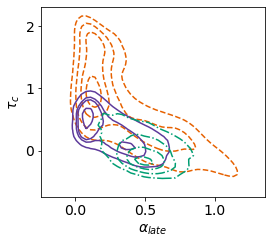

In [16]:
# Zoom in on a_late vs. tau_c
plt.rcParams.update({
    'font.size': 14,
    #"figure.figsize": (5, 3.25),
})

fig, ax = plt.subplots(figsize = (4,3.5))
prop_labels = [r"$M_{peak}(z=0)$", r"$\alpha_{early}$", r"$\alpha_{late}$", r"$\tau_c$", r"$z_{10}$", r"$z_{25}$", r"$z_{50}$", r"$z_{80}$", r"$c_{200c}$", r"$\Delta x/r_{200c}$"]
colors = ["#E66100", "#5D3A9B", "#009E73"]
linestyles =['--', '-', '-.']
param_1 = 2
param_2 = 3
which_params = [param_1, param_2]
#bin_edges = [(bin_edges[5][0], 1.2), (bin_edges[7][0], 0.8)]
for i, data in enumerate([pickled_non_params[:,which_params], pickled_fg_only_params[:,which_params], pickled_qh_only_params[:,which_params]]):
    fig, ax = _plot_2d_hist(data[:,0], data[:,1], bin_edges[which_params[0]], bin_edges[which_params[1]], levels=[0.1, 0.35, 0.65, 0.9], ax = ax, colors = colors[i], linestyles = linestyles[i])

ax.set_xlabel(prop_labels[param_1])
ax.set_ylabel(prop_labels[param_2])

#plt.tight_layout()
#fig.savefig("full_lj_plots/diffmah_a_late_tau_c.png", bbox_inches='tight', pad_inches=0)

## Make full zoom plot

/home/acossairt/miniconda3/envs/fossil_groups_env/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: The following kwargs were not used by contour: 'linestyle', 'linewidth'


4


/home/acossairt/miniconda3/envs/fossil_groups_env/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/acossairt/miniconda3/envs/fossil_groups_env/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator


Text(0.22, -0.5, '3')

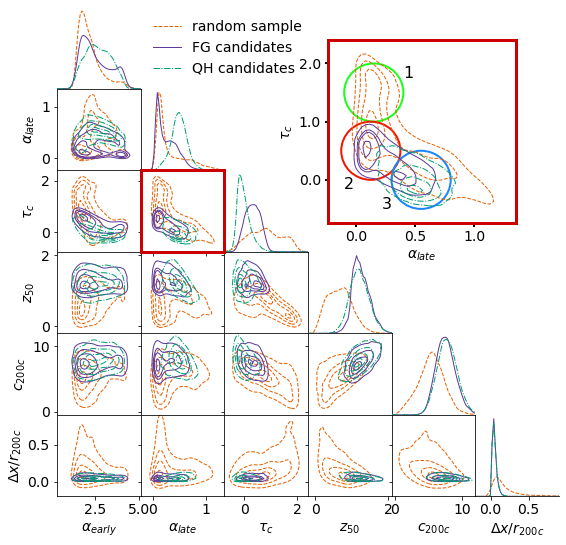

<Figure size 648x648 with 0 Axes>

In [17]:
prop_labels = np.array([r"$M_{peak}(z=0)$", r"$\alpha_{early}$", r"$\alpha_{late}$", r"$\tau_c$", r"$z_{10}$", r"$z_{25}$", r"$z_{50}$", r"$z_{80}$", r"$c_{200c}$", r"$\Delta x/r_{200c}$"])
colors = ["#E66100", "#5D3A9B", "#009E73"]
data_labels = ["random sample", "FG candidates", "QH candidates"]

# Make bin edges
global_mins = [np.Inf for p in range(pickled_non_params.shape[1])] # HARD CODE (but should all be the same?)
global_maxs = [-np.Inf for p in range(pickled_non_params.shape[1])]
for data in [pickled_non_params, pickled_fg_only_params, pickled_qh_only_params]:
    mins = [np.min(data[:, p]) for p in range(data.shape[1])] # list containing min value of each property
    maxs = [np.max(data[:, p]) for p in range(data.shape[1])] # data.shape[1] = nparams
    global_mins = [min(mins[p], global_mins[p]) for p in range(data.shape[1])]
    global_maxs = [max(maxs[p], global_maxs[p]) for p in range(data.shape[1])]
    
bin_edges = [(global_mins[p] - 0.2*(global_maxs[p] - global_mins[p]), global_maxs[p]) for p in range(data.shape[1])]
bin_edges[3] = (-0.75, bin_edges[3][1] + 0.1) # Manually adjust max for transition times, z80s, and relaxations
bin_edges[6] = (-0.2, 2.1)
bin_edges[7] = (bin_edges[7][0], 1.2)
bin_edges[8] = (-0.5, 12)
bin_edges[9] = (-0.2, 0.9)
bin_edges = np.array([np.linspace(*be, 51, endpoint=True) for be in bin_edges])

# Plot zoomy plots!
fig = plt.figure(figsize=(9, 9))
fig, axes = jointplot(pickled_non_params[:, [1,2,3,6,8,9]], pickled_fg_only_params[:, [1,2,3,6,8,9]], pickled_qh_only_params[:, [1,2,3,6,8,9]], levels=[0.1, 0.35, 0.65, 0.9], colors = colors, linestyles = ["--", "-", "-."], bin_edges = bin_edges[[1,2,3,6,8,9]], prop_labels = prop_labels[[1,2,3,6,8,9]], data_labels = data_labels, fig=fig, linewidth = 1)
axes[0, 0].legend(loc='upper left', bbox_to_anchor=(1,1), frameon=False)
zoom_ax, fig = create_zoom(fig, axes[2,1], zoom_relsize=2.25, zoom_padding=0.8)
zoom_ax.set(xlabel=prop_labels[2], ylabel=prop_labels[3])

green_circle = Ellipse((.15, 1.5), .5, 1, edgecolor = "#1AFF1A", fill = False, linewidth = 2)
red_circle = Ellipse((.125, .5), .5, 1, edgecolor = "#F01700", fill = False, linewidth = 2)
blue_circle = Ellipse((.55, 0), .5, 1, edgecolor = "#1A85FF", fill = False, linewidth = 2)
zoom_ax.add_artist(green_circle)
zoom_ax.add_artist(red_circle)
zoom_ax.add_artist(blue_circle)
zoom_ax.annotate(r"1", (.4, 1.75), fontsize = 16)
zoom_ax.annotate(r"2", (-0.1, -0.15), fontsize = 16)
zoom_ax.annotate(r"3", (0.22, -0.5), fontsize = 16)
#fig.savefig("full_lj_plots/diffmah_zoom.pdf", bbox_inches='tight', pad_inches=0, dpi=300)

## Search for "near-QH"s
A QH is a halo which never experienced even one major merger. What about halos that experienced exactly one? Could these explain the "tail" of the FG distribution which extends into the "blue circle" zone? (see above for "blue circle)

In [113]:
# Normally, these names will include "only" -- that's a problem left over from a typo
pickled_non_subset = pickle.load( open( "save_rs_subset.p", "rb" ))
pickled_fg_only_subset = pickle.load( open( "save_fg_subset.p", "rb" ))
pickled_qh_only_subset = pickle.load( open( "save_qh_subset.p", "rb" ))

In [115]:
mainbranch_index, mainbranch_mass = help_func_haccytrees.get_branches(pickled_fg_only_subset, fg_forest)
mainbranch_mergers = help_func_haccytrees.get_mainbranch_mergers(fg_forest, fg_progenitor_array, mainbranch_index)
major_mergers = help_func_haccytrees.get_major_mergers(mainbranch_mergers)

# count major_mergers
major_mergers[major_mergers > 0] = 1
mm_sum = np.sum(major_mergers, axis = 1)

# mask for halos with exactly one major merger
one_major_merger = mm_sum == 1
near_qhs = pickled_fg_only_subset[one_major_merger]
near_qh_params = pickled_fg_only_params[one_major_merger]

Text(0, 0.5, '$\\tau_c$')

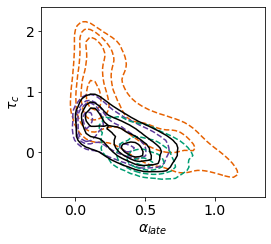

In [154]:
plt.rcParams.update({
    'font.size': 14,
})

fig, ax = plt.subplots(figsize = (4,3.5))
prop_labels = [r"$M_{peak}(z=0)$", r"$\alpha_{early}$", r"$\alpha_{late}$", r"$\tau_c$", r"$z_{10}$", r"$z_{25}$", r"$z_{50}$", r"$z_{80}$", r"$c_{200c}$", r"$\Delta x/r_{200c}$"]
colors = ["#E66100", "#5D3A9B", "#009E73", "black"]
linestyles =['--', '--', '--', "-"]

# Choose your parameters (look at "prop_labels" for help)
param_1 = 2
param_2 = 3
which_params = [param_1, param_2]

# Plot the 2D parameter space, including near QHs
for i, data in enumerate([pickled_non_params[:,which_params], pickled_fg_only_params[:,which_params], pickled_qh_only_params[:,which_params], near_qh_params[:,which_params]]):
    fig, ax = _plot_2d_hist(data[:,0], data[:,1], bin_edges[which_params[0]], bin_edges[which_params[1]], levels=[0.1, 0.35, 0.65, 0.9], ax = ax, colors = colors[i], linestyles = linestyles[i])

ax.set_xlabel(prop_labels[param_1])
ax.set_ylabel(prop_labels[param_2])

#plt.tight_layout()
#fig.savefig("full_lj_plots/diffmah_a_early_z80.png", bbox_inches='tight', pad_inches=0)

## Alternatively, if you'd rather have overlapping samples

In [ ]:
%%time
# Pick a mass bin
mass_bin = 0
my_fg_mask = fg_masks[mass_bin]
my_halo_mask = halo_masks[mass_bin]

# Find qhs within fg_forest
fg_rugs_idx = np.nonzero(my_fg_mask)[0]
fg_rugs_mainbranch_index, fg_rugs_mainbranch_masses = help_func_haccytrees.get_branches(fg_rugs_idx, fg_forest)
fg_rugs_mainbranch_mergers = help_func_haccytrees.get_mainbranch_mergers(fg_forest, fg_progenitor_array, fg_rugs_mainbranch_index)
fg_rugs_major_mergers = help_func_haccytrees.get_major_mergers(fg_rugs_mainbranch_mergers)
fg_rugs_lmm_redshift = help_func_haccytrees.get_lmms(fg_rugs_major_mergers)
fgs, qhs, mrich = help_func_haccytrees.find_specials(fg_forest, fg_rugs_mainbranch_index, fg_rugs_major_mergers, fg_rugs_lmm_redshift, fg_rugs_idx)

# Define sample sizes
rs_sample_size = 1000
fg_sample_size = 1000
if qhs != []:
    qh_sample_size = 1000 #len(rugs)
    size = fg_sample_size + qh_sample_size + rs_sample_size
else:
    qh_sample_size = 0 #len(rugs)
    size = fg_sample_size + rs_sample_size
    
# Create subsets
np.random.seed(0)
rs_idx = np.nonzero(my_halo_mask)[0]
rs_subset = np.random.choice(rs_idx, rs_sample_size)
fg_subset = np.random.choice(fg_rugs_idx, fg_sample_size)
if qhs != []:
    qh_subset = np.random.choice(qhs, qh_sample_size)

pickle.dump(rs_subset, open( "save_rs_subset.p", "wb" ))
pickle.dump(fg_subset, open( "save_fg_subset.p", "wb" ))
pickle.dump(qh_subset, open( "save_qh_subset.p", "wb" ))

In [ ]:
%%time
#rs_tpeak = cosmic_time[np.argmax(rs_subset, axis=1)] # Do we still need this part?
rs_best_fit_params, rs_log_mah_fits, rs_dmdts = calc_subset_params(rs_subset, forest) # p_init is shape of number of params. How many params do I have? 3 fg, rugs, rs, but are those really parameters?
fg_best_fit_params, fg_log_mah_fits, fg_dmdts = calc_subset_params(fg_subset, fg_forest) 
qh_best_fit_params, qh_log_mah_fits, qh_dmdts = calc_subset_params(qh_subset, fg_forest)

In [ ]:
pickle.dump(rs_best_fit_params, open( "save_new_rs_list.p", "wb" ))
pickle.dump(fg_best_fit_params, open( "save_new_fg_list.p", "wb" ))
pickle.dump(qh_best_fit_params, open( "save_new_qh_list.p", "wb" ))

pickle.dump(rs_log_mah_fits, open( "save_new_rs_log_mah_fits.p", "wb" ))
pickle.dump(fg_log_mah_fits, open( "save_new_fg_log_mah_fits.p", "wb" ))
pickle.dump(qh_log_mah_fits, open( "save_new_qh_log_mah_fits.p", "wb" ))

pickle.dump(rs_dmdts, open( "save_new_rs_dmdts.p", "wb" ))
pickle.dump(fg_dmdts, open( "save_new_fg_dmdts.p", "wb" ))
pickle.dump(qh_dmdts, open( "save_new_qh_dmdts.p", "wb" ))

In [ ]:
pickled_rs_params = pickle.load( open( "save_new_rs_list.p", "rb" ))
pickled_fg_params = pickle.load( open( "save_new_fg_list.p", "rb" ))
pickled_qh_params = pickle.load( open( "save_new_qh_list.p", "rb" ))

pickled_rs_log_mah_fits = pickle.load( open("save_new_rs_log_mah_fits.p", "rb" ))
pickled_fg_log_mah_fits = pickle.load( open("save_new_fg_log_mah_fits.p", "rb" ))
pickled_qh_log_mah_fits = pickle.load( open("save_new_qh_log_mah_fits.p", "rb" ))

pickled_rs_dmdts = pickle.load( open("save_new_rs_dmdts.p", "rb" ))
pickled_fg_dmdts = pickle.load( open("save_new_fg_dmdts.p", "rb" ))
pickled_qh_dmdts = pickle.load( open("save_new_qh_dmdts.p", "rb" ))

In [ ]:
pickled_rs_subset = pickle.load( open( "save_rs_subset.p", "rb" ))
pickled_fg_subset = pickle.load( open( "save_fg_subset.p", "rb" ))
pickled_qh_subset = pickle.load( open( "save_qh_subset.p", "rb" ))
#print(pickled_rs_subset)

In [ ]:
plt.rcParams.update({
    'font.size': 14,
    "figure.figsize": (10, 10), #(5.2, 3.13), #(5.4, 3.25), #(5.83, 3.5),#(6.25, 4.25), #(6.25, 3.75)
})

global_mins = [np.Inf for p in range(pickled_rs_params.shape[1])] # HARD CODE (but should all be the same?)
global_maxs = [-np.Inf for p in range(pickled_rs_params.shape[1])]
for data in [pickled_rs_params, pickled_fg_params, pickled_qh_params]:
    mins = [np.min(data[:, p]) for p in range(data.shape[1])] # list containing min value of each property
    maxs = [np.max(data[:, p]) for p in range(data.shape[1])] # data.shape[1] = nparams 
    global_mins = [min(mins[p], global_mins[p]) for p in range(data.shape[1])]
    global_maxs = [max(maxs[p], global_maxs[p]) for p in range(data.shape[1])]

basic_bin_edges = [(global_mins[p], global_maxs[p]) for p in range(1, data.shape[1])]
bin_edges = [(global_mins[p] - 0.1*(global_maxs[p] - global_mins[p]), global_maxs[p]) for p in range(1, data.shape[1])]
bin_edges[6] = (bin_edges[6][0], 1.2) # Manually adjust max for z80s and relaxations
bin_edges[8] = (bin_edges[8][0], 0.8)
bin_edges = [np.linspace(*be, 51, endpoint=True) for be in bin_edges]
#print(bin_edges)

colors = ["#E66100", "#5D3A9B", "#1BB17E"] #green "#009E73" # light blue "#5AC8E9"]# blue "#1AA3CB"]"#CC6677"
prop_labels = [r"$\alpha_{early}$", r"$\alpha_{late}$", r"$\tau_c$", r"$z_{10}$", r"$z_{25}$", r"$z_{50}$", r"$z_{80}$", r"$c_{200c}$", r"$\Delta x/r_{200c}$"]
data_labels = ["random sample", "FG candidates", "QH candidates"]
fig, axes = jointplot(pickled_rs_params[:,1:], pickled_fg_params[:,1:], pickled_qh_params[:,1:], levels=[0.1, 0.35, 0.65, 0.9], prop_labels = prop_labels, data_labels = data_labels, bin_edges = bin_edges, colors = colors, linewidth = 1, linestyles=["--", "-", "-."])
axes[1,1].legend(loc='lower left', bbox_to_anchor=(1,1), frameon=False)
fig.suptitle("overlapping samples")
fig.savefig("diffmah_new_z10.png")